In [12]:
# analysis on metamaterial antenna with Neural Networks

import pandas as pd
import numpy as np

df = pd.read_csv('antenna.csv')

In [13]:
df.head()

,Wm,W0m,dm,tm,rows,Xa,Ya,gain,vswr,bandwidth,s,pr,p0
0,2142.9,162.86,77.143,214.29,3.0,3543.5,2142.9,2.799175,1.372040,110.6698,-16.090654,0.204248,0.483952
1,2142.9,162.86,77.143,214.29,3.0,3543.5,6964.3,2.817305,1.638103,120.7497,-12.328015,0.197374,0.464289
2,2142.9,162.86,351.430,214.29,5.0,8365.0,6964.3,2.941413,1.242714,123.6901,-19.313586,0.212885,0.490808
3,2142.9,162.86,351.430,214.29,3.0,8365.0,2142.9,2.844078,1.242587,122.4301,-19.317644,0.212405,0.496603
4,2142.9,162.86,351.430,214.29,3.0,8365.0,6964.3,2.812315,1.271176,124.3198,-18.459992,0.207997,0.489240


In [14]:
print( "Columns: " , len(df.columns))
print("Rows: " , len(df.rows))

Columns:  13
Rows:  572


In [15]:
# check for null

print(df.isnull().sum())

Wm            0
W0m           0
dm            0
tm            0
rows          0
Xa            0
Ya            0
gain          0
vswr          0
bandwidth    63
s             0
pr            0
p0            0
dtype: int64


In [16]:
# in Neural network we put 0 in null values

df.fillna(value=0, inplace=True)
print(df.isnull().sum())

Wm           0
W0m          0
dm           0
tm           0
rows         0
Xa           0
Ya           0
gain         0
vswr         0
bandwidth    0
s            0
pr           0
p0           0
dtype: int64


In [17]:
# define x and y

x = df.drop('bandwidth', axis=1)
y = df['bandwidth']

In [18]:
# converting to numpy array

x = x.iloc[:,:].values
y = y.iloc[:].values

In [19]:
# train-test split

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2)

In [20]:
# normalization x -> (x-ave)/std                (based on train_data average and std)

from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc.fit(x_train)
x_train = sc.transform(x_train)
x_test = sc.transform(x_test)

In [21]:
# NN Structure for our <<regression>> problem

from keras.models import Sequential
from keras.layers import Dense

def build_model():
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=(12,)))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

In [22]:
# K-fold validation
# because our amount of data is low

k=5
num_val_samples = len(x_train)//k
num_epochs=500
all_mae_histories = []
for i in range(k):
    print("processing fold #",i+1)
    x_val = x_train[i*num_val_samples: (i+1)*num_val_samples]
    y_val = y_train[i*num_val_samples:(i+1)*num_val_samples]
    partial_x_train = np.concatenate([x_train[:i*num_val_samples], x_train[(i+1)*num_val_samples:]],axis=0)
    partial_y_train = np.concatenate([y_train[:i*num_val_samples], y_train[(i+1)*num_val_samples:]], axis=0)
    model = build_model()
    history = model.fit(partial_x_train, partial_y_train, validation_data=(x_val, y_val),
                       epochs=num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)

processing fold # 1
processing fold # 2
processing fold # 3
processing fold # 4
processing fold # 5


In [23]:
# Building the history of successive mean K-fold validation scores

average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)
]

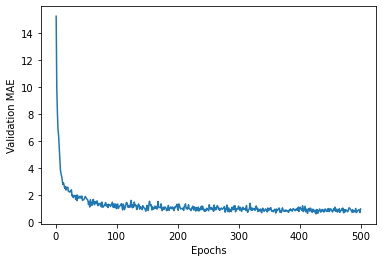

In [24]:
# Plotting validation scores

import matplotlib.pyplot as plt

plt.plot(range(1,len(average_mae_history)+1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

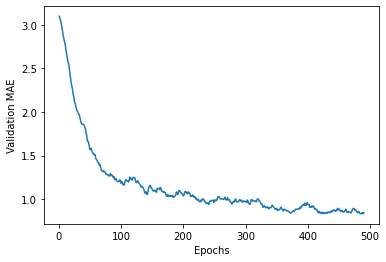

In [25]:
# remove first 10 data points and smoothing the curve

def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous*factor+point*(1-factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.clf()
plt.plot(range(1, len(smooth_mae_history)+1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [27]:
# final score

test_mse_score, test_mae_score = model.evaluate(x_test, y_test)
print('test mae score: ', test_mae_score)


4/4 [==============================] - 0s 2ms/step - loss: 0.7393 - mae: 0.6588
test mae score:  0.6587653756141663


In [ ]:
# Our model is very good !!!